<a href="https://colab.research.google.com/github/Hritik003/Optimization-of-OWC-using-ML-models/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/OWC'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/OWC


In [3]:
df = pd.read_excel("Data_simple_OWC.xlsx")

In [4]:
df

,b/h,a/h,T_0,P_OWC
0,0.5,0.1,4.00,6166.015694
1,0.5,0.1,4.25,7425.068412
2,0.5,0.1,4.50,7204.635913
3,0.5,0.1,4.75,6980.917023
4,0.5,0.1,5.00,6212.720913
...,...,...,...,...
2875,4.0,0.8,14.00,7444.916425
2876,4.0,0.8,14.25,7845.898568
2877,4.0,0.8,14.50,8246.424103
2878,4.0,0.8,14.75,8645.654850


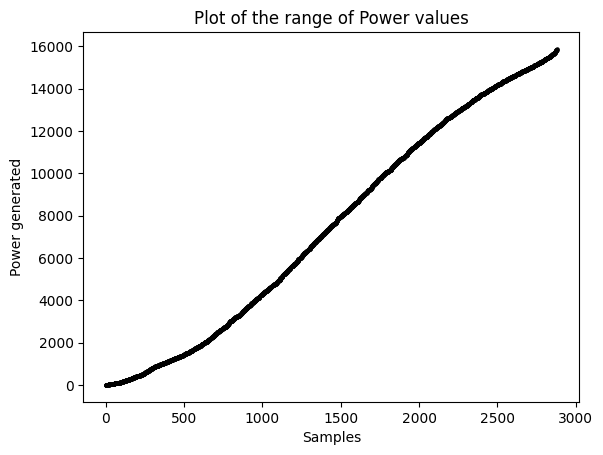

In [6]:
unique_vals = df.iloc[:,3].unique()
unique_vals = sorted(unique_vals)
for i in range(len(unique_vals)):
    plt.scatter(i,unique_vals[i], color='black', s=5)
plt.xlabel('Samples')
plt.ylabel('Power generated')
plt.title('Plot of the range of Power values')
plt.show()

In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
x_max = X.max()
x_min=X.min()
y_max = y.max()
y_min = y.min()
X = (X - x_min)/(x_max-x_min)
y = (y - y_min)/(y_max-y_min)
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(2880, 3) (2880,)


In [6]:
X_train,y_train

(           b/h       a/h       T_0
 2133  0.714286  1.000000  0.409091
 2008  0.714286  0.571429  0.636364
 278   0.000000  0.857143  0.181818
 1225  0.428571  0.428571  0.227273
 2241  0.857143  0.142857  0.818182
 ...        ...       ...       ...
 1638  0.571429  0.571429  0.409091
 1095  0.428571  0.000000  0.340909
 1130  0.428571  0.142857  0.113636
 1294  0.428571  0.571429  0.772727
 860   0.285714  0.428571  0.113636
 
 [2016 rows x 3 columns],
 2133    0.115902
 2008    0.727024
 278     0.284569
 1225    0.288550
 2241    0.895438
           ...   
 1638    0.474592
 1095    0.735018
 1130    0.000727
 1294    0.920347
 860     0.151536
 Name: P_OWC, Length: 2016, dtype: float64)

# DNN

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [8]:
def create_regression_dnn(input_shape):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))

    model.add(layers.Dense(1024, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    # model.add(layers.Dropout(0.1))

    model.add(layers.Dense(512, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    # model.add(layers.Dropout(0.1))

    model.add(layers.Dense(256, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    # model.add(layers.Dropout(0.1))

    model.add(layers.Dense(128, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    # model.add(layers.Dropout(0.1))

    model.add(layers.Dense(64, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    # model.add(layers.Dropout(0.1))

    model.add(layers.Dense(1, activation='linear'))

    return model

input_shape = X_train.shape[1]
model = create_regression_dnn(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              4096      
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 512)               0

In [9]:
initial_learning_rate = 0.02
decay_steps = 50
decay_rate = 0.9

# Create a learning rate schedule
def learning_rate_scheduler(epoch):
    return initial_learning_rate * decay_rate**(epoch / decay_steps)

# Instantiate your optimizer with the initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

history = model.fit(X_train, y_train, epochs=2000, batch_size=64, validation_split=0.2,callbacks=[lr_scheduler_callback])
# ,callbacks=[lr_scheduler_callback]

Epoch 1/2000
26/26 [==============================] - 12s 145ms/step - loss: 0.4707 - mae: 0.4707 - val_loss: 1.1977 - val_mae: 1.1977 - lr: 0.0200
Epoch 2/2000
26/26 [==============================] - 1s 55ms/step - loss: 0.1394 - mae: 0.1394 - val_loss: 0.1835 - val_mae: 0.1835 - lr: 0.0200
Epoch 3/2000
26/26 [==============================] - 1s 31ms/step - loss: 0.1398 - mae: 0.1398 - val_loss: 0.1798 - val_mae: 0.1798 - lr: 0.0199
Epoch 4/2000
26/26 [==============================] - 1s 24ms/step - loss: 0.1219 - mae: 0.1219 - val_loss: 0.2206 - val_mae: 0.2206 - lr: 0.0199
Epoch 5/2000
26/26 [==============================] - 1s 23ms/step - loss: 0.1328 - mae: 0.1328 - val_loss: 0.2160 - val_mae: 0.2160 - lr: 0.0198
Epoch 6/2000
26/26 [==============================] - 1s 22ms/step - loss: 0.1456 - mae: 0.1456 - val_loss: 0.2757 - val_mae: 0.2757 - lr: 0.0198
Epoch 7/2000
26/26 [==============================] - 1s 23ms/step - loss: 0.1181 - mae: 0.1181 - val_loss: 0.2450 - val_m

In [10]:
# model.load_weights('wt.h5')

In [22]:
y_pred = model.predict(X_test)
y_test = y_test.to_numpy()
# from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

# # Assuming y_pred and y_test are arrays or lists containing predicted and actual values respectively
# # Calculate MAE
# mae = mean_absolute_error(y_test, y_pred)
# print(mae*(y_max-y_min))
# mape = mean_absolute_percentage_error(y_test, y_pred)

# print("Mean Absolute Percentage Error (MAPE):", mape)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error (RMSE):", rmse*(y_max-y_min))

27/27 [==============================] - 0s 4ms/step
Root Mean Squared Error (RMSE): 728.7316560759797


In [12]:
y_pred_2= model.predict(X_train)
# # y_train = y_train.to_numpy()
# # Assuming y_pred and y_test are arrays or lists containing predicted and actual values respectively
# # Calculate MAE
# mae = mean_absolute_error(y_train, y_pred_2)
# print(mae*(y_max-y_min))

# mape = mean_absolute_percentage_error(y_train, y_pred_2)
# print("Mean Absolute Percentage Error (MAPE):", mape) # 2.743%
# rmse = np.sqrt(mean_squared_error(y_train, y_pred_2))

# print("Root Mean Squared Error (RMSE):", rmse*(y_max-y_min))

63/63 [==============================] - 0s 4ms/step
304.6584603899358
Mean Absolute Percentage Error (MAPE): 18483765122.314762
Root Mean Squared Error (RMSE): 728.7316560759797


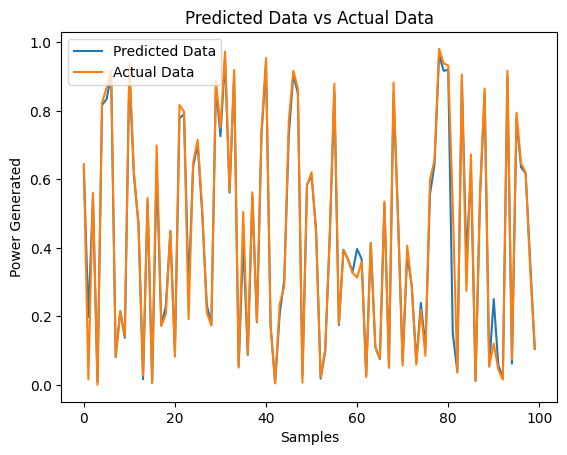

In [26]:
plt.plot(y_pred[100:200],label='Predicted Data')
plt.plot(y_test[100:200], label = 'Actual Data')
plt.xlabel('Samples')
plt.ylabel('Power Generated')
plt.title('Predicted Data vs Actual Data')
plt.legend()
plt.show()

In [14]:

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)

-2.275553313418433


In [ ]:
# print(average_absolute_difference.numpy()*(y_max-y_min))

5811.386417820207


In [ ]:
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

train_mae = history.history['loss']
val_mae = history.history['val_loss']

In [ ]:
# model.save_weights('wt_2.h5')

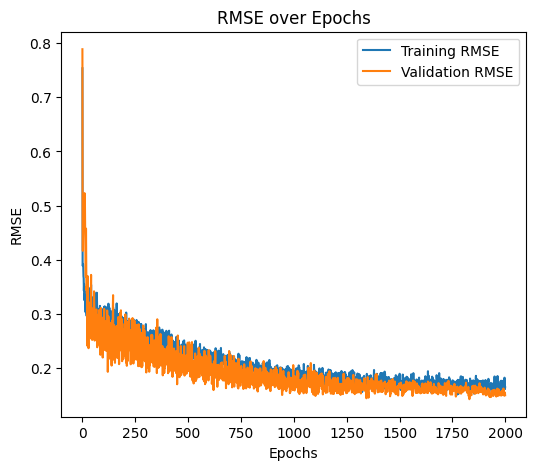

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

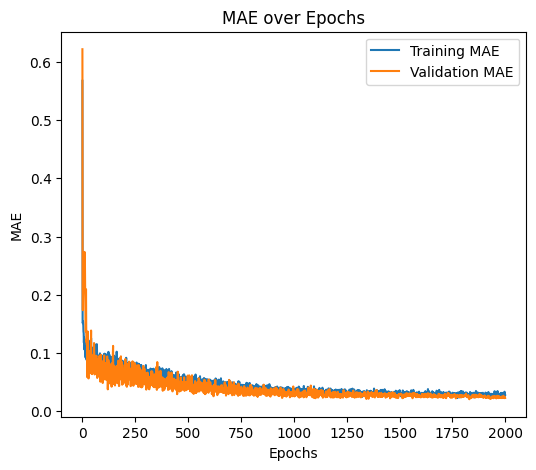

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

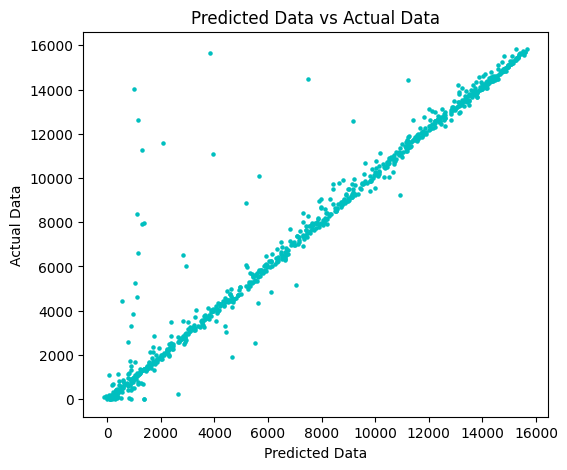

In [ ]:
plt.figure(figsize=(6, 5))
for i in range(y_test.shape[0]):
  plt.scatter(y_pred[i]*(y_max-y_min),y_test[i]*(y_max-y_min),color='c',s=5)
# plt.plot(train_mae, label='Training MAE')
# plt.plot(val_mae, label='Validation MAE')
plt.title('Predicted Data vs Actual Data')
plt.xlabel('Predicted Data')
plt.ylabel('Actual Data')
plt.show()

In [ ]:
train_mape = 0
test_mape = 0
for i in range(len(y_test)):
  test_mape += (abs(y_pred[i]-y_test[i])/y_test[i])
print(test_mape*100/len(y_test))

[3393.2087] 0.48339839858254374
[392.73248]


In [ ]:
print(len(y_test))

864


In [ ]:
0.027*(y_max-y_min)

428.79296424992367

# Genetic Algo

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
from deap import base, creator, tools, algorithms

In [ ]:
def evaluate(individual):
    model = create_regression_dnn(input_shape=(X_train.shape[1],))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.set_weights(individual)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    loss = history.history['loss'][-1]
    return loss,

In [ ]:
import random

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=calculate_total_params())
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)

algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)

best_individual = hof[0]
best_model = create_regression_dnn(input_shape=(X_train.shape[1],))
best_model.compile(optimizer='adam', loss='mean_squared_error')
best_model.set_weights(best_individual)

ValueError: You called `set_weights(weights)` on layer "sequential_1" with a weight list of length 701441, but the layer was expecting 32 weights. Provided weights: [0.22179142489302395, 0.5869497193398803, 0.829278...